In [1]:
from __future__ import print_function

import numpy as np
from keras.datasets import imdb
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.layers import LSTM, Convolution1D, MaxPooling1D, GlobalAveragePooling1D, concatenate, Lambda, BatchNormalization
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from six.moves import cPickle as pickle
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, LambdaCallback

import matplotlib.pyplot as plt

# fix random seed for reproducibility
seed=7
np.random.seed(seed)
import tensorflow as tf
tf.set_random_seed(seed)

NAME="MODEL-11-conv-1.0"
split_valid_test=False

Using TensorFlow backend.


```
# Read data
with open("Atmosfera-Incidents-2017.pickle", 'rb') as f:
    incidents = pickle.load(f)
# Skonwertuj root_service do intów i zapisz 
Y=[int(i) for i in incidents[1:,3]]
with open("Y.pickle", 'wb') as f:
    pickle.dump(Y, f, pickle.HIGHEST_PROTOCOL)
```

In [2]:
# Dane wejściowe
with open("X-sequences.pickle", 'rb') as f:
    X = pickle.load(f)
with open("Y.pickle", 'rb') as f:
    Y = pickle.load(f)
    

In [3]:
# Zostaw tylko poniższe kategorie, pozostale zmień na -1
lista = [2183, 
         #325, 
         37, 859, 2655, 606, 412, 2729, 1683, 1305]
# Y=[y if y in lista else -1 for y in Y]
mask = [y in lista for y in Y]

import itertools
X = np.array(list(itertools.compress(X, mask)))
Y = np.array(list(itertools.compress(Y, mask)))

In [4]:
np.unique(Y)

array([  37,  412,  606,  859, 1305, 1683, 2183, 2655, 2729])

W tej wersji eksperymentu, Y zawiera root_service - 44 unikalne kategorie główne. 
Zamieńmy je na liczby z przedziału 0-43

In [5]:
root_services=np.sort(np.unique(Y))
# skonstruuj odwrtotny indeks kategorii głównych
services_idx={root_services[i]: i for i in range(len(root_services))}

In [6]:
# Zamień 
Y=[services_idx[y] for y in Y]

In [7]:
Y=to_categorical(Y)
Y.shape

(14830, 9)

In [8]:
top_words = 5000
classes=Y[0,].shape[0]
print(classes)

9


In [9]:
# max_length (98th percentile is 476), padd the rest
max_length=500
X=sequence.pad_sequences(X, maxlen=max_length)



# slice in half even/odds to nulify time differencies
X_train=X[0:][::2] # even
X_test=X[1:][::2] # odds

Y_train=np.array(Y[0:][::2]) # even
Y_test=np.array(Y[1:][::2]) # odds

if split_valid_test:
    # Split "test" in half for validation and final testing
    X_valid=X_test[:len(X_test)/2]
    Y_valid=Y_test[:len(Y_test)/2]
    X_test=X_test[len(X_test)/2:]
    Y_test=Y_test[len(Y_test)/2:]
else:
    X_valid=X_test
    Y_valid=Y_test

In [10]:
# create the model
embedding_vecor_length = 60

_input = Input(shape=(max_length,), name='input')
embedding=Embedding(top_words, embedding_vecor_length, input_length=max_length)(_input)

conv1 = Conv1D(filters=128, kernel_size=1, padding='same', activation='relu')
conv2 = Conv1D(filters=128, kernel_size=2, padding='same', activation='relu')
conv3 = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')
conv4 = Conv1D(filters=128, kernel_size=4, padding='same', activation='relu')
conv5 = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')
conv6 = Conv1D(filters=32, kernel_size=6, padding='same', activation='relu')

conv1 = conv1(embedding)
glob1 = GlobalAveragePooling1D()(conv1)
conv2 = conv2(embedding)
glob2 = GlobalAveragePooling1D()(conv2)
conv3 = conv3(embedding)
glob3 = GlobalAveragePooling1D()(conv3)
conv4 = conv4(embedding)
glob4 = GlobalAveragePooling1D()(conv4)
conv5 = conv5(embedding)
glob5 = GlobalAveragePooling1D()(conv5)
conv6 = conv6(embedding)
glob6 = GlobalAveragePooling1D()(conv6)

merge = concatenate([glob1, glob2, glob3, glob4, glob5, glob6])
x = Dropout(0.2)(merge)
x = BatchNormalization()(x)
x = Dense(300, activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
pred = Dense(classes, activation='softmax')(x)

model = Model(inputs=[_input], outputs=pred)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])#, decay=0.0000001)

print(model.summary())


# Callbacks
early_stop_cb = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

checkpoit_cb = ModelCheckpoint(NAME+".h5", save_best_only=True)

# Print the batch number at the beginning of every batch.
batch_print_cb = LambdaCallback(on_batch_begin=lambda batch, logs: print (".",end=''), 
                                on_epoch_end=lambda batch, logs: print (batch))

# Plot the loss after every epoch.
plot_loss_cb = LambdaCallback(on_epoch_end=lambda epoch, logs: 
                              print (epoch, logs))
                              #plt.plot(np.arange(epoch), logs['loss']))

print("done")

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               (None, 500)           0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 500, 60)       300000      input[0][0]                      
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 500, 128)      7808        embedding_1[0][0]                
____________________________________________________________________________________________________
conv1d_2 (Conv1D)                (None, 500, 128)      15488       embedding_1[0][0]                
___________________________________________________________________________________________

In [11]:
history = model.fit(
        X,#_train,
        Y,#_train,
#        initial_epoch=1200,
        epochs=1500,
        batch_size=2048,
        #validation_data=(X_valid,Y_valid),
        validation_split=0.25,
        callbacks=[early_stop_cb, checkpoit_cb, batch_print_cb, plot_loss_cb],
        verbose=0
        )

#history=model.fit(X_train, Y_train, validation_data=(X_test, Y_test), nb_epoch=3, batch_size=512)

......0
0 {'val_acc': 0.29045307825941358, 'acc': 0.22235209696735758, 'val_loss': 2.1972081329444464, 'loss': 2.2907942968442958}
......1
1 {'val_acc': 0.38754044040764291, 'acc': 0.45135766988048404, 'val_loss': 1.8211152232066199, 'loss': 1.6764864422095549}
......2
2 {'val_acc': 0.5361380996956151, 'acc': 0.56374752620123547, 'val_loss': 1.5606886738712349, 'loss': 1.2684236450217607}
......3
3 {'val_acc': 0.47114348257243827, 'acc': 0.58793382772415836, 'val_loss': 5.2719509748193438, 'loss': 1.3116221091576219}
......4
4 {'val_acc': 0.580366770233537, 'acc': 0.59197986184896867, 'val_loss': 2.8518192837539229, 'loss': 1.2276255778755307}
......5
5 {'val_acc': 0.60409927387453588, 'acc': 0.64997303079645574, 'val_loss': 2.1651286851240981, 'loss': 1.0553123873786261}
......6
6 {'val_acc': 0.59924490693574839, 'acc': 0.6727207338632043, 'val_loss': 2.1094584989702048, 'loss': 0.96001683015056793}
......7
7 {'val_acc': 0.60544769657211139, 'acc': 0.69061319948293132, 'val_loss': 1.8

......62
62 {'val_acc': 0.84142392995931059, 'acc': 0.90568242864500725, 'val_loss': 0.44824172062909845, 'loss': 0.264214736151408}
......63
63 {'val_acc': 0.83872706482454151, 'acc': 0.90891925647862848, 'val_loss': 0.45720918728952914, 'loss': 0.25413832791126839}
......64
64 {'val_acc': 0.84573895562170909, 'acc': 0.91098723125809322, 'val_loss': 0.44338655767574536, 'loss': 0.25009644442840651}
......65
65 {'val_acc': 0.84439054211880915, 'acc': 0.91548282147054083, 'val_loss': 0.45743334476616004, 'loss': 0.24079575418697119}
......66
66 {'val_acc': 0.84088458231737695, 'acc': 0.91053767345552283, 'val_loss': 0.45074453409821469, 'loss': 0.24339439583390635}
......67
67 {'val_acc': 0.83899675340199809, 'acc': 0.91710124053750997, 'val_loss': 0.45197918747492466, 'loss': 0.23328486259110945}
......68
68 {'val_acc': 0.84492992223144991, 'acc': 0.92087753604500655, 'val_loss': 0.45333293652585921, 'loss': 0.22741374746969847}
......69
69 {'val_acc': 0.84196334324994138, 'acc': 0.924

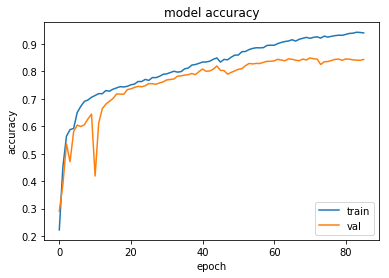

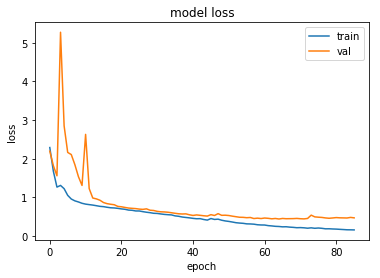

In [12]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
# plt.title('model loss (log scale)')
# plt.yscale('log')
plt.show()

In [60]:

history2 = model.fit(
        X,#_train,
        Y,#_train,
        initial_epoch=10000,    
        epochs=10010,
        batch_size=1024,
        #validation_data=(X_valid,Y_valid),
        validation_split=0.1,
        callbacks=[early_stop_cb, checkpoit_cb, batch_print_cb, plot_loss_cb],
        verbose=0
        )    

..............10000
10000 {'acc': 0.92942234211274544, 'loss': 0.24218799137770838, 'val_acc': 0.82063384744981138, 'val_loss': 0.60090364376114414}
..............10001
10001 {'acc': 0.91623585825423015, 'loss': 0.2689954228043297, 'val_acc': 0.82130815604210539, 'val_loss': 0.57255609547537245}
..............10002
10002 {'acc': 0.91256462126767102, 'loss': 0.26002808122422494, 'val_acc': 0.82198247745562791, 'val_loss': 0.55839366890334308}
..............10003
10003 {'acc': 0.91676032069364077, 'loss': 0.2551032062205445, 'val_acc': 0.81726230352373441, 'val_loss': 0.5396233856557433}
..............10004
10004 {'acc': 0.90971753953538725, 'loss': 0.26793382654272591, 'val_acc': 0.82333110135226983, 'val_loss': 0.54280942650317177}
..............10005
10005 {'acc': 0.91331385330929871, 'loss': 0.25824233047893597, 'val_acc': 0.81928523625382199, 'val_loss': 0.55742760879802122}
..............10006
10006 {'acc': 0.90664568818302349, 'loss': 0.28339036189188821, 'val_acc': 0.805124744883

In [15]:
score=model.evaluate(X_test,Y_test, verbose=0)
print("OOS %s: %.2f%%" % (model.metrics_names[1], score[1]*100))
print("OOS %s: %.2f" % (model.metrics_names[0], score[0]))

NameError: name 'X_test' is not defined

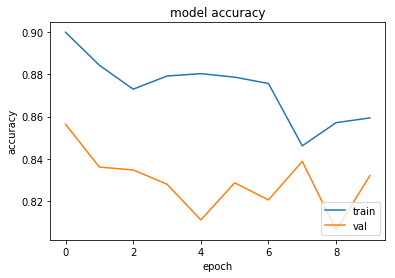

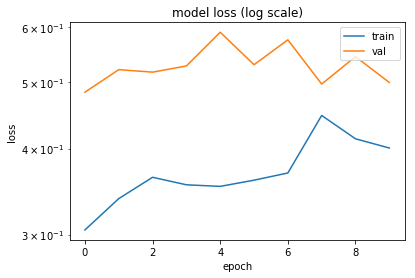

In [50]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()


# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss (log scale)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.yscale('log')
plt.show()

In [15]:
history3 = model.fit(
        X,#_train,
        Y,#_train,
        initial_epoch=60,    
        epochs=90,
        batch_size=1024,
        #validation_data=(X_valid,Y_valid),
        validation_split=0.3,
        callbacks=[early_stop_cb, checkpoit_cb, batch_print_cb, plot_loss_cb],
        verbose=0
        )

................60
60 {'acc': 0.69396716357036081, 'loss': 1.0682002606852541, 'val_acc': 0.61906176239181299, 'val_loss': 1.4453319599962575}
................61
61 {'acc': 0.7037037048871484, 'loss': 1.0332637657505632, 'val_acc': 0.61564727237275552, 'val_loss': 1.4414969362725554}
................62
62 {'acc': 0.70701285371711209, 'loss': 1.0041220267947522, 'val_acc': 0.62232779267281646, 'val_loss': 1.4268438312050282}
................63
63 {'acc': 0.71197658232548955, 'loss': 0.99611397675313584, 'val_acc': 0.62262470591946051, 'val_loss': 1.4255109716764256}
................64
64 {'acc': 0.71834033401439978, 'loss': 0.97293814648437305, 'val_acc': 0.62069477901889136, 'val_loss': 1.4260232516535671}
................65
65 {'acc': 0.72184039811467771, 'loss': 0.97190722480626812, 'val_acc': 0.61935867436424852, 'val_loss': 1.4186554088162131}
................66
66 {'acc': 0.72578592269766862, 'loss': 0.94906096593772571, 'val_acc': 0.62024940674208684, 'val_loss': 1.40941029149959

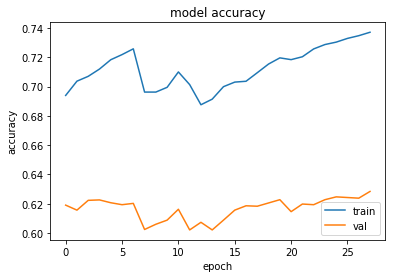

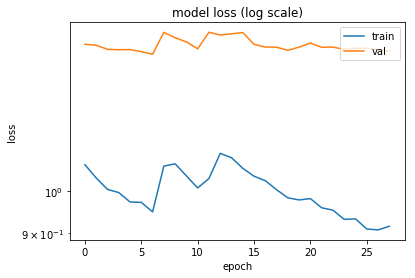

In [16]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history3.history['acc'])
plt.plot(history3.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()


# summarize history for loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss (log scale)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.yscale('log')
plt.show()